In [91]:
### PreProcessing ###
import json
import pandas as pd 
import numpy as np
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer


### NMF ###

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize

### LDA ###

import gensim
import nltk
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
import matplotlib.pyplot as plt 
from pprint import pprint

### BTM ###

import bitermplus as btm
from biterm.utility import vec_to_biterms
from biterm.cbtm import oBTM
from biterm.btm import oBTM

### Corex ###

import scipy.sparse as ss
import corextopic.corextopic as ct
from gensim.models.nmf import Nmf
from gensim.models import CoherenceModel

In [75]:
data_file = open("/Users/mike/Desktop/INF2290/yelp_academic_dataset_review.json")
data = []
i=0
for line in data_file:
    data.append(json.loads(line))
    i+=1
    if i ==100000:
        break
df = pd.DataFrame(data)
data_file.close()

In [76]:
### Data pre-processing ###

In [77]:

### remove punctuation ###

df["processed_text"] = df['text'].str.replace('[^\w\s]','')

### convert uppercase to lowercase letters ###

df['processed_text'] = \
df['processed_text'].map(lambda x: x.lower())


### remove columns ###

df = df.drop(columns = ['review_id', 'user_id', 'business_id', 'useful', 'funny', 'cool', 'text', 'date'])

/var/folders/vn/snkbxk1s7w14425jjpssy9lc0000gn/T/ipykernel_71590/3046982958.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["processed_text"] = df['text'].str.replace('[^\w\s]','')


NameError: name 'porter' is not defined

In [5]:
df['stars'] = df['stars'].astype(int)

In [6]:
three_star_review = df[df['stars'] == 3] 

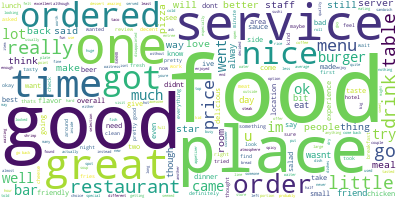

In [7]:
# Import the wordcloud library

# Join the different processed titles together.
long_string = ','.join(list(three_star_review['processed_text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [8]:
### LDA ###

In [9]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'wow', 'went', 'now', 'got', 'ive', 'youre', 'us', 'im'])

def sent_word(sentence): 
    for sentence in sentence:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_words(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]   

data = three_star_review.processed_text.values.tolist()
data_words = list(sent_word(data))

data_words = remove_words(data_words)

print(data_words[:1])

[['decide', 'eat', 'aware', 'going', 'take', 'hours', 'beginning', 'end', 'tried', 'multiple', 'times', 'want', 'like', 'locations', 'nj', 'never', 'bad', 'experience', 'food', 'good', 'takes', 'long', 'time', 'come', 'waitstaff', 'young', 'usually', 'pleasant', 'many', 'experiences', 'spent', 'way', 'long', 'waiting', 'usually', 'opt', 'another', 'diner', 'restaurant', 'weekends', 'order', 'done', 'quicker']]


In [10]:
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [11]:
def LDA(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = num_topics, random_state = 100, 
                                               chunksize = 200, passes = 10, per_word_topics = True, id2word = id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [70]:
model_list, coherence_values = LDA(dictionary = id2word, 
                                   corpus = corpus, 
                                   texts = texts,
                                   start = 2, 
                                   limit = 17, 
                                   step =1)

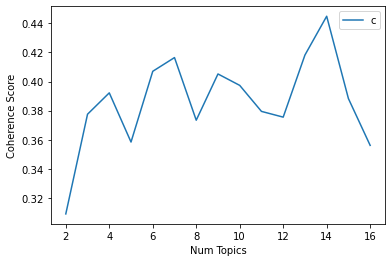

In [71]:
limit = 17; start = 2; step = 1;
model1 = range(start, limit, step)
plt.plot(model1, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

In [73]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.065*"music" + 0.056*"fun" + 0.054*"far" + 0.047*"wings" + 0.047*"name" + '
  '0.044*"beers" + 0.035*"red" + 0.024*"twice" + 0.024*"afternoon" + '
  '0.023*"charge"'),
 (1,
  '0.051*"good" + 0.045*"food" + 0.032*"place" + 0.023*"great" + '
  '0.022*"service" + 0.020*"would" + 0.018*"really" + 0.017*"nice" + '
  '0.014*"pretty" + 0.013*"back"'),
 (2,
  '0.120*"burger" + 0.119*"fries" + 0.062*"anything" + 0.050*"fast" + '
  '0.045*"expensive" + 0.044*"burgers" + 0.042*"potato" + 0.037*"return" + '
  '0.025*"arent" + 0.024*"run"'),
 (3,
  '0.040*"like" + 0.031*"get" + 0.030*"one" + 0.020*"dont" + 0.015*"go" + '
  '0.013*"even" + 0.013*"think" + 0.012*"people" + 0.012*"still" + '
  '0.011*"lot"'),
 (4,
  '0.105*"cream" + 0.091*"ice" + 0.049*"buffet" + 0.045*"making" + '
  '0.027*"cook" + 0.027*"interior" + 0.021*"using" + 0.020*"reservations" + '
  '0.018*"lamb" + 0.018*"setting"'),
 (5,
  '0.085*"room" + 0.054*"hotel" + 0.042*"old" + 0.036*"front" + '
  '0.036*"someone" + 0.033*"

In [15]:
perplexity = lda_model.log_perplexity(corpus)

In [16]:
# lower the score the better #
print(perplexity)

-8.204629843141252


In [17]:
# coherence #
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-2.6461532541405157


In [18]:
### NNMF ###

In [19]:
three_star_review['processed_text'] = three_star_review['processed_text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

/var/folders/vn/snkbxk1s7w14425jjpssy9lc0000gn/T/ipykernel_71590/1988962722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_star_review['processed_text'] = three_star_review['processed_text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))


In [20]:
yelp_data = three_star_review['processed_text']

In [21]:
yelp_data

0        decide eat aware going take 2 hours beginning ...
2        family diner buffet eclectic assortment large ...
8        easter instead going lopez lake los padres nat...
9        party 6 hibachi waitress brought separate sush...
21       upland brewery based bloomington indiana becom...
                               ...                        
99948    hot humid evening friend decided order vermice...
99971    pros comfotable hotel bed pillows ever slept g...
99976    shiny new stadium ooh ahh think initial excite...
99982    tried withing cabbage mac cheese id rate 710wo...
99990    tough review place say atmosphere really nice ...
Name: processed_text, Length: 11362, dtype: object

In [22]:
vectorizer = CountVectorizer(analyzer='word', max_features=5000);
x_counts = vectorizer.fit_transform(yelp_data);

In [23]:
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

In [24]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [82]:
num_topics = 7

In [83]:
model = NMF(n_components=num_topics, init='nndsvd');

In [84]:
model.fit(xtfidf_norm)

NMF(init='nndsvd', n_components=7)

In [85]:
def nmf_topics(model, n_top_words):
    feat_names = vectorizer.get_feature_names()
    word_dict = {};
    for i in range(num_topics):
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [86]:
nmf_topics(model, 20)

/Users/mike/mambaforge/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07
0,placing,gotta,pjs,football,chilis,oldest,greeting
1,goodbut,prevent,crunchy,serve,buses,speak,behavior
2,tilapia,placing,delight,slider,organization,noticed,placing
3,gin,called,awesome,awesome,fruit,placing,attempt
4,light,pricier,tooth,response,fries,write,bargain
5,onsite,serve,chef,death,said,nieces,seek
6,squid,realizing,place,ole,chef,honesty,dress
7,badly,seek,wings,froyo,sampler,ticket,gambling
8,worthy,overhead,organic,quality,satisfaction,brewery,nieces
9,dj,thinking,slab,listen,flight,goodbut,mushroom


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(num_topics[0]), coherence)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('coherence', fontsize=16);

In [ ]:
### NMF with gensim ###

In [55]:
def create_nmf_model(id_dict, corpus, num_topics):
    nmf_model = Nmf(corpus=corpus,
                    id2word=id_dict,
                    num_topics=num_topics, 
                    random_state=100,
                    chunksize=100,
                    passes=50)
    return nmf_model

In [72]:
def plot_coherence(id_dict, corpus, texts):
    num_topics_range = range(2, 15)
    coherences = []
    for num_topics in num_topics_range:
        nmf_model = create_nmf_model(id_dict, corpus, 
                                     num_topics)
        coherence_model_nmf = \
        CoherenceModel(model=nmf_model, texts=texts, 
                       dictionary=id_dict, 
                       coherence='c_v')
        coherences.append(
            coherence_model_nmf.get_coherence())
    plt.plot(num_topics_range, coherences, 
             color='blue', marker='o', markersize=5)
    plt.title('Coherence as a function of number of \
              topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.grid()
    plt.show()

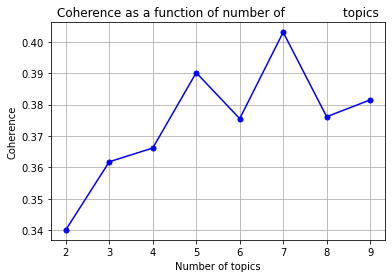

In [58]:
plot_coherence(id2word, corpus, texts)

In [30]:
### CorEx ###

In [33]:
vectorizer = CountVectorizer(stop_words='english', max_features=5000);
tfidf_corex = vectorizer.fit_transform(yelp_data);
doc_word = ss.csr_matrix(tfidf_corex)

In [34]:
words = list(np.asarray(vectorizer.get_feature_names()))

/Users/mike/mambaforge/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [95]:
topic_model = ct.Corex(n_hidden=10, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [96]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: sauce, chicken, cheese, fried, flavor, salad, meat, rice, pork, cooked
1: minutes, time, took, asked, told, waited, said, wait, arrived, waiting
2: room, hotel, rooms, stay, stayed, clean, parking, pool, desk, floor
3: like, dont, know, going, people, want, way, feel, thing, thats
4: experience, make, right, review, let, new, getting, work, times, started
5: bar, beer, night, drinks, drink, music, beers, outside, place, friends
6: ordered, came, table, menu, meal, server, seated, order, food, restaurant
7: really, didnt, try, wasnt, think, maybe, little, pretty, probably, thought
8: store, nice, items, need, pros, cons, day, shop, stores, space
9: cream, taste, chocolate, ice, sweet, dessert, cake, flavors, butter, crust


In [37]:
print(topic_model.tc)

9.661184175982887


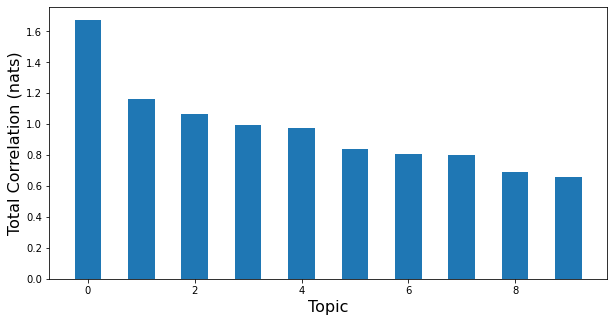

In [38]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation', fontsize=16);

In [39]:
### btm ###

In [40]:
X, vocabulary, vocab_dict = btm.get_words_freqs(yelp_data, stop_words=stop_words)

In [41]:
docs_vec = btm.get_vectorized_docs(yelp_data, vocabulary)
biterms = btm.get_biterms(docs_vec)

In [97]:
model_btm = btm.BTM(
X, vocabulary, seed=12321, T=8, M=20, alpha=50/8, beta=0.01)
model_btm.fit(biterms, iterations=20)

TypeError: fit_transform() takes at least 2 positional arguments (1 given)

In [43]:
p_zd = model_btm.transform(docs_vec)

100%|██████████████████████████████████| 11362/11362 [00:00<00:00, 62612.24it/s]


In [104]:
top_docs = btm.get_top_topic_docs(
    texts,
    p_zd,
    docs_num=20,
    topics_idx=[1,2,3,4])

/Users/mike/mambaforge/lib/python3.9/site-packages/bitermplus/_util.py:225: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = Series(np.asarray(docs)[idx])


In [105]:
top_docs

,topic1,topic2,topic3,topic4
0,"[cigarettes, one, favorite, movies, dirty, franks, might, well, bar, featured, movie, id, expect, see, courtney, love, drunk, corner, booth, ben, affleck, pouring, pints, slaughtering, pick, lines, janeane, garofalo, wearing, black, discussing, beatnik, culture, fellow, intellectuals, kate, hudson, sitting, bar, dress, lamenting, lost, love, paul, rudd, consoling, christina, ricci, chainsmoking, outside, dave, chapelle, pulls, disco, cab, franks, melting, pot, local, flavor, like, movie, gets, personality]","[lindo, parque, otima, vegetacao, cuidados, porem, quantidade, de, mendigos, drogados, que, frequentam, parque, lastimavel, sugiro, um, maior, policiamento, algum, servico, social, para, encaminhar, estes, mendigos]","[missed, ourconnecting, flight, weather, stayed, rooms, clean, bed, comfy, would, stay]",[]
1,"[report, card, steak, tacos, guacamoleb, tortilla, chipsc, serviceb, cleanliness, price]","[megaplex, sometimes, helpful, staff]","[hotel, livable, dated, exhaust, bathroom, air, cond, noisy, effective, rate, paid, stayed, sheraton, canal, hotel, staff, friendly, location, good]","[großes, hotel, auf, der, bourbon, st, welche, man, sich, wie, eine, mischung, aus, reeperbahn, und, ballermann, vorstellen, kann, wenn, man, ein, zimmer, zur, straße, hin, erwischt, hat, man, verloren, es, sein, denn, man, geht, selbst, nie, vor, ins, bett, zimmer, nach, hinten, raus, oder, zum, innenhof, sind, prima, auch, nebenstraße, geht, hotel, hat, vier, sterne, ist, entsprechend, unpersonlich, bis, unhoflich, typisch, amerikanisch, hier, may, help, aber, wenn, man, dann, wirklich, ein, problem, hat, ist, es, mit, der, freundlichkeit, schnell, vorbei, das, beste, ist, noch, der, jazzclub, der, bar, der, wirklich, mit, die, besten, musiker, der, stadt, prasentiert, ansonsten, es, gibt, ...]"
2,"[say, head, right, back, staircase, go, hurricanes, go, peoplewatch, provoke, beadseeking, tourists, balcony, quite, fun]","[perhaps, bit, jaded, right, applying, grad, schools, mba, iupui, charges, send, transcripts, schools, every, school, want, apply, pay, application, fee, give, iupui, every, transcript, didnt, give, enough, money, throughout, years, undergrad, want, gouge, much, money, humanly, possible, many, colleagues, applying, grad, schools, issue, colleges, send, transcripts, free, charge, must, nice]","[nice, neighborhood, bar, smoking, secure, locked, front, door, uniformed, door]","[bbq, beans, delicious, tripi, chimichurri, seasoned, well]"
3,"[decent, cocktails, recommended, large, groups, bar, tries, salonstyle, furniture, decor, look, ad, hoc, curb, steals, salon, speakeasy, charm, much, prefer, ranstead, room]","[estimate, another, plumber, highest, quote, plumbers, interviewed, job, prompt, communication, though, reconsider, future, jobs, seems, reliable, often, get, pay]","[hella, uncomfortable, seats, equivalent, plastic, stools, outlets, wifi, slow, af, cuties]","[mehnothing, special, ok]"
4,"[looooooooove, itwut, great, cell, phone, storeespecially, live, santa, barbraand, place, nice, amount, space, happy, get, helped]","[mom, bought, groupon, archery, lessons, lane, rental, facility, nice, however, dont, bother, lessons, involved, less, five, minutes, instruction, would, visit, facility, wouldnt, bother, lessons]","[brookes, music, needs, go, pop, edm]","[presentation, nicetaste, mediocreservers, clue, roll, whatmakes, wonder]"
5,"[evening, started, great, min, seated, ordering, served, cocktails, eletricity, offfor, entire, time, till, leftdrinks, house, since, tolerated, uncomfortable, situation, guedt, town]","[stayed, one, night, dec, getting, snowed, nashvilleyep, snowed, fun, place, staykinda, vegas, style, accommodations, someone, gets, vegas, times, year, say, enjoyed, staying, downtown, hermitageand, choice, next, time, head, nashville]","[would, say, rockledge, nail, salon, hit, miss, manicures, pedicures, generally, goodbut, waxing, problematic, get, one, inexperienced, girls

In [44]:
perplexity = model_btm.perplexity_
coherence = model_btm.coherence_

In [51]:
print(perplexity, coherence)

2267.0495504012615 [-262.42203748 -287.68841336 -270.3409683  -260.82639542 -353.65838374
 -330.93054771 -289.10248285 -282.41688754]


In [52]:
pd.set_option('display.max_colwidth', None)


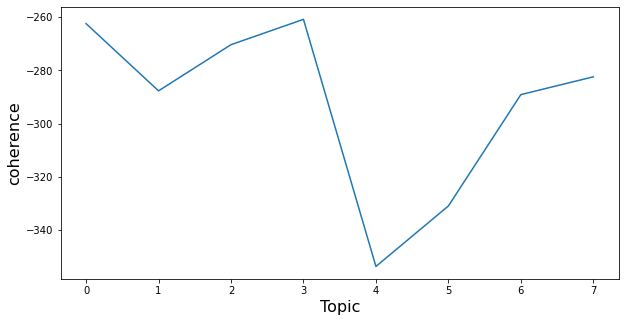

In [53]:
plt.figure(figsize=(10,5))
plt.plot(range(model_btm.matrix_topics_words_.shape[0]), coherence)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('coherence', fontsize=16);